https://www.kaggle.com/sudalairajkumar/simple-exploration-baseline-santander-value

https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc

In [1]:
import os
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [40]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [5]:
labeled = pd.read_csv(r'../data/train.csv')
print(labeled.shape)

(4459, 4993)


In [6]:
labeled.columns

Index(['ID', 'target', '48df886f9', '0deb4b6a8', '34b15f335', 'a8cb14b00',
       '2f0771a37', '30347e683', 'd08d1fbe3', '6ee66e115',
       ...
       '3ecc09859', '9281abeea', '8675bec0b', '3a13ed79a', 'f677d4d13',
       '71b203550', '137efaa80', 'fb36b89d9', '7e293fbaf', '9fc776466'],
      dtype='object', length=4993)

### Take a look at the Y distribution
- Might want to take log of right-skewed money values (non-neg; log(Y)~normal => good for linear regression)

Text(0.5,1,'Target Histogram')

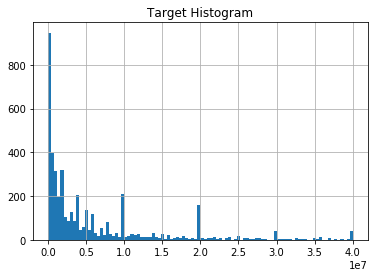

In [7]:
labeled['target'].hist(bins=100)
plt.title("Target Histogram")

Text(0.5,1,'Log Target Histogram')

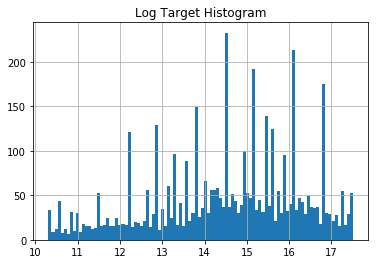

In [8]:
labeled['target'].map(np.log).hist(bins=100)
plt.title('Log Target Histogram')

### Take a look at X
- missing values?
- data types?
- constants?

In [9]:
missing_df = labeled.isnull().sum(axis=0).reset_index()
missing_df.columns=['col','NAs']
missing_df[missing_df.NAs!=0]

,col,NAs


In [10]:
dtype_df = labeled.dtypes.reset_index()
dtype_df.groupby(0).count() # all numeric

,index
0,
int64,3147
float64,1845
object,1


In [11]:
constant_df = labeled.nunique().reset_index()
constant_df.columns = ['col','unique_vals']
len(constant_df[constant_df.unique_vals==1])

256

In [12]:
const_col = list(constant_df[constant_df.unique_vals==1].col.values)
len(const_col)

256

In [14]:
labeled.drop(labels=const_col,axis=1,inplace=True)
print(labeled.shape)

(4459, 4737)


In [15]:
%%time
test = labeled.iloc[:,1:10]
corr=test.corr()

CPU times: user 3.62 ms, sys: 2.62 ms, total: 6.24 ms
Wall time: 5.7 ms


In [16]:
labeled[['target','48df886f9']].corr().values[0,1]

0.010188021496986742

In [17]:
%%time
feature_dict={}
for feature in labeled.columns[2:]:
    feature_dict[feature] = labeled[['target',feature]].corr().values[0,1]

CPU times: user 3.58 s, sys: 16.2 ms, total: 3.59 s
Wall time: 3.62 s


In [18]:
feat_corr_df = pd.DataFrame.from_dict(feature_dict, orient='index').reset_index()
feat_corr_df.columns = ['feat','corr']
feat_corr_df['corr_abs'] = feat_corr_df['corr'].map(np.abs)

In [19]:
feat_corr_df.sort_values('corr_abs',ascending=False)[:20]

,feat,corr,corr_abs
4476,555f18bd3,0.273379,0.273379
2617,9fd594eec,0.270019,0.270019
2342,5bc7ab64f,0.267858,0.267858
3337,cbbc9c431,0.265005,0.265005
4135,f190486d6,0.263821,0.263821
4707,6b119d8ce,0.258290,0.258290
4190,f74e8f13d,0.257238,0.257238
570,ac30af84a,0.256292,0.256292
537,26fc93eb7,0.255186,0.255186
2378,58e2e02e6,0.254984,0.254984


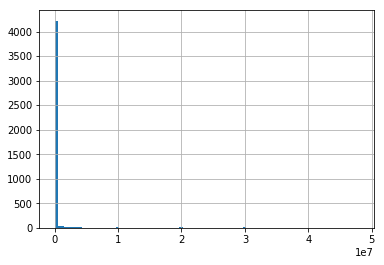

In [20]:
labeled['555f18bd3'].hist(bins=100)

In [21]:
labeled[labeled['555f18bd3']!=0].shape # ok, very sparse

(324, 4737)

In [22]:
feature_sparse_dict={}
for feature in labeled.columns[2:]:
    feature_sparse_dict[feature] = len(labeled[labeled[feature]!=0])

In [23]:
feat_sparse_df = pd.DataFrame.from_dict(feature_sparse_dict,orient='index').reset_index()
feat_sparse_df.columns = ['feat','values']
print(feat_sparse_df['values'].describe())
feat_sparse_df.sort_values('values',ascending=False)[:5]

count    4735.000000
mean      147.858289
std       216.818376
min         1.000000
25%        15.000000
50%        70.000000
75%       180.000000
max      1565.000000
Name: values, dtype: float64


,feat,values
4321,c5a231d81,1565
1953,0ff32eb98,1565
2934,91f701ba2,1560
4513,c47340d97,1555
3816,adb64ff71,1547


In [24]:
feats = pd.merge(feat_corr_df, feat_sparse_df,how='inner',on='feat')
print(feats.shape)
feats[:3]

(4735, 4)


,feat,corr,corr_abs,values
0,48df886f9,0.010188,0.010188,39
1,0deb4b6a8,0.013805,0.013805,4
2,34b15f335,0.014694,0.014694,33


In [52]:
## Take the top non-sparse linear features
feats.sort_values(['values','corr_abs'],ascending=[False,False])[:40]

,feat,corr,corr_abs,values
1953,0ff32eb98,0.191524,0.191524,1565
4321,c5a231d81,0.191321,0.191321,1565
2934,91f701ba2,0.206891,0.206891,1560
4513,c47340d97,0.213456,0.213456,1555
545,0572565c2,0.201068,0.201068,1547
3816,adb64ff71,0.199026,0.199026,1547
4135,f190486d6,0.263821,0.263821,1544
4033,5c6487af1,0.209962,0.209962,1539
4346,e176a204a,0.191612,0.191612,1535
645,6619d81fc,0.200045,0.200045,1533


In [53]:
top_non_sparse_feat = feats.sort_values(['values','corr_abs'],ascending=[False,False])[:40]['feat'].values.tolist()

In [54]:
# y = labeled['target']
y = np.log(labeled['target']) # Take the log of y
X = labeled[top_non_sparse_feat]

In [55]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,random_state=1)

In [30]:
ln = LinearRegression()
ln.fit(X_train,y_train)
print(ln.score(X_train,y_train))
y_pred = ln.predict(X_val)

0.0948001033024


In [31]:
y_pred_exp = np.exp(y_pred)

In [37]:
def rmsle(pred, val):
    return(np.sqrt(((np.log(pred+1) - np.log(val+1))**2).mean()))

In [38]:
rmsle(y_pred_exp,y_val)

11.754650184411762

In [43]:
rf = RandomForestRegressor(n_estimators=300,random_state=1)
rf.fit(X_train,y_train)
y_pred2 = rf.predict(X_val)
rmsle(np.exp(y_pred2),y_val)

11.729388854083552

### Apply on test

In [33]:
test = pd.read_csv(r'../data/test.csv')
print(test.shape)
test[:3]

(49342, 4992)


,ID,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000137c73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00021489f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0004d7953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
X_test = test[top_non_sparse_feat]

In [45]:
pred_target1 = np.exp(ln.predict(X_test))
pred_target2 = np.exp(rf.predict(X_test))

In [48]:
output = pd.concat([test['ID'],pd.Series((pred_target1+pred_target2)/2)],axis=1)
output.columns=['ID','target']

In [49]:
# Changed to log, negatives should no longer exist
output.loc[output.target<0,'target']

Series([], Name: target, dtype: float64)

In [50]:
output.to_csv('../output/0807_logY_40_nonsp_feat_lr+rf.csv',index=False)